![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

**Copyright:** 2025 EUMETSAT <br>
**License:** MIT <br>
**Authors:** Serena Avolio (EUMETSAT/Starion)

<div class="alert alert-block alert-success">
<h3>EODAG - DestinE Data Lake Provider (DEDL) </h3> </div>

<div class="alert alert-block alert-warning">
<b> Prerequisites: </b>
   <li>To search and access DEDL data a <a href="https://platform.destine.eu/"> DestinE user account</a> is needed</li>
<b> References: </b>
    <li><a href="https://eodag.readthedocs.io/en/stable/index.html">EODAG - Earth Observation Data Access Gateway</a> </li>
    <li><a href="https://destine-data-lake-docs.data.destination-earth.eu/en/latest/dedl-discovery-and-data-access/Introduction-to-Discovery-and-Data-Access-services/Introduction-to-Discovery-and-Data-Access-services.html#eodag-earth-observation-data-access-gateway">EODAG - DEDL</a> </li>
    <li> <a href="https://eodag.readthedocs.io/en/stable/api_user_guide.html">EODAG API documentation</a></li>
<b> Credit: </b>
    <li> Code used in this context takes inspiration from the <a href="https://eodag.readthedocs.io/en/stable/api_user_guide.html">Python API User Guide</a> produced by CS Group.</li>
</div>

EODAG is a command line tool and a Python package for searching and downloading earth observation data via a unified API. 

This tutorial demonstrates how to use EODAG to search and access DEDL data. 
The notebook uses the DEDL provider in EODAG to access data via Python code.


1. [Setup](HDA-EODAG-full-version.ipynb#Setup): *EODAG* configuration to use the provider *DEDL* .
2. [Search](HDA-EODAG-full-version.ipynb#Search): search *DEDL* data, we search for Sentinel-3 data.
3. [Filter](HDA-EODAG-full-version.ipynb#Filter): filter *DEDL* data. 
4. [Download](HDA-EODAG-full-version.ipynb#Download): download *DEDL* data.

The complete guide on how to use EODAG Python API is available via https://eodag.readthedocs.io/en/stable/api_user_guide.html.

<div class="alert alert-block alert-danger">
<b> Note:</b>
    
Please note that the two factor authentication (2FA) is still not implemented in EODAG. The users who have enabled 2FA on DESP will not be able to run this notebook.
</div>

## Setup
In this section, we set:
- The output_dir, the directory where to store downloaded products.
- The DEDL credentials, you'll be asked to enter your DEDL credentials.
- The search timeout, it is of 60 seconds to avoid any unexpected errors because of long running search queries. 

In [1]:
import os
from getpass import getpass

workspace = 'eodag_workspace'
if not os.path.isdir(workspace):
    os.mkdir(workspace)
    
os.environ["EODAG__DEDL__DOWNLOAD__OUTPUT_DIR"] = os.path.abspath(workspace)
#os.environ["EODAG__DEDL__DOWNLOAD__OUTPUTS_PREFIX"] = os.path.abspath(workspace)

os.environ["EODAG__DEDL__PRIORITY"]="10"
os.environ["EODAG__DEDL__SEARCH__TIMEOUT"]="60"


DESP_USERNAME = input("Please input your DESP username or email: ")
DESP_PASSWORD = getpass("Please input your DESP password: ")

os.environ["EODAG__DEDL__AUTH__CREDENTIALS__USERNAME"]=DESP_USERNAME
os.environ["EODAG__DEDL__AUTH__CREDENTIALS__PASSWORD"]=DESP_PASSWORD


Please input your DESP username or email:  eum-dedl-user
Please input your DESP password:  ········


### Import EODAG and list available products on DEDL

We now need to import the EODataAccessGateway class. The class is going to take care of  all the following operations.

We can start listing the **products available using dedl as provider.**

In [6]:

from eodag import EODataAccessGateway, setup_logging
dag = EODataAccessGateway()

setup_logging(0)

In [34]:
print("\033[1mID - Title\033[0m")

# Rows
for pt in dag.list_product_types("dedl"):
    print(f'{pt["ID"]} - {pt["title"]}')

ID - Title
EO.AERIS.DAT.IAGOS - In-service Aircraft for a Global Observing System
EO.CLMS.DAT.CORINE - CORINE Land Cover
EO.CLMS.DAT.GLO.DMP300_V1 - 10-daily Dry Matter Productivity 333M
EO.CLMS.DAT.GLO.FAPAR300_V1 - Global 10-daily Fraction of Absorbed PAR 333m
EO.CLMS.DAT.GLO.FCOVER300_V1 - Global 10-daily Fraction of Vegetation Cover 333m
EO.CLMS.DAT.GLO.GDMP300_V1 - 10-daily Gross Dry Matter Productivity 333M
EO.CLMS.DAT.GLO.LAI300_V1 - Global 10-daily Leaf Area Index 333m
EO.CLMS.DAT.GLO.NDVI300_V1 - Global 10-daily Normalized Difference Vegetation Index 333M
EO.CLMS.DAT.GLO.NDVI_1KM_V2 - Normalized Difference Vegetation Index: global Long Term Statistics (raster 1km) - version 2, Apr 2019
EO.CLMS.DAT.SENTINEL-2.HRVPP.VI - Vegetation Indices, daily, UTM projection
EO.DEM.DAT.COP-DEM_GLO-30-DGED - Copernicus DEM GLO-30 DGED
EO.DEM.DAT.COP-DEM_GLO-30-DTED - Copernicus DEM GLO-30 DTED
EO.DEM.DAT.COP-DEM_GLO-90-DGED - Copernicus DEM GLO-90 DGED
EO.DEM.DAT.COP-DEM_GLO-90-DTED - Coperni

## Search

To search we use the *search* method passing the ID of our dataset of interest and a geo-time filter. 

The *search* method returns a *SearchResult* object that stores the products obtained from a given page (default: page=1) and a given maximum number of items per page (default: items_per_page=20). 

In the following cell, **we change the default value of *items_per_page* and define the search criteria to retrieve Sentinel-2 MSI Level-2 images over Sicily, first days of July 2024. Our goal is to check whether any effects of Mount Etna’s eruptions during that period are visible in the Sentinel-2 imagery.**

In [35]:
search_criteria = {
    "provider":"dedl",
    "productType": "EO.ESA.DAT.SENTINEL-2.MSI.L2A",
    "start": "2024-07-04T07:00:00.00Z",
    "end": "2024-07-08T07:00:00.00Z",
    "geom": {"lonmin": 12, "latmin": 37, "lonmax": 16, "latmax": 39},
    "count": True,
    "items_per_page": 50
}

In [36]:
products_first_page = dag.search(**search_criteria)

Results are stored in a 'SearchResult' object that contains the details on the single search result.

In [37]:
products_first_page

SearchResult([EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T32SQF_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33STB_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SVC_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SWC_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33STC_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SUD_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SUA_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33STA_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SWB_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SUB_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SWA_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T32SQG_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SWD_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SVD_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SUC_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SVB_20240705T122657, provider=dedl),
              EOProduct(id=S2B_MSIL2A_20240705T094549_N0510_R079_T33SVA_20240705T122657, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SWC_20240707T131659, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SWB_20240707T131659, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SVA_20240707T131659, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SWD_20240707T131659, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SWA_20240707T131659, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SVC_20240707T131659, provider=dedl),
              EOProduct(id=S2A_MSIL2A_20240707T094041_N0510_R036_T33SVB_20240707T131659, provider=dedl)])

It is possible to list the metadata associated with a certain product, we choose the first one returned [0], and look into it.

In [38]:
one_product = products_first_page[0]
one_product.properties.keys()

dict_keys(['alias', 'abstract', 'instrument', 'platform', 'platformSerialIdentifier', 'processingLevel', 'keywords', 'sensorType', 'license', 'title', 'missionStartDate', '_id', 'productType', 'publicationDate', 'orbitNumber', 'cloudCover', 'modificationDate', 'sensorMode', 'startTimeFromAscendingNode', 'completionTimeFromAscendingNode', 'id', 'downloadLink', 'thumbnail', 'storageStatus', 'defaultGeometry', 'quicklook', 'providers', 'start_datetime', 'sat:absolute_orbit', 'sar:product_type', 'dedl:processorVersion', 'dedl:sourceProductOriginDate', 'dedl:uid', 'dedl:datastripId', 'dedl:beginningDateTime', 'dedl:sourceProduct', 'dedl:productGroupId', 'dedl:endingDateTime', 'dedl:origin', 'dedl:scope', 'dedl:granuleIdentifier', 'dedl:tileIdentifier'])

In [39]:
one_product.properties['cloudCover']

0.000265

## Filter

EODAG can filter the search result. **We can then refine our initial search without asking the provider again.
Products can be filtered according to their properties or also with finer geometry filters.**


The following example shows how to filter products to keep only those whose cloud coverage is less than 20%. And then restrict the results to products containing a smaller area over the mount Etna.

Let's define now a smaller area around the mount Etna and a function to see the area on a map together with the results

In [40]:
from eodag.crunch import FilterProperty
from eodag.crunch import FilterOverlap
import shapely
import folium
from shapely.geometry import Polygon

small_geom = Polygon([[15.1, 37.7], [15.5, 37.7], [15.1, 37.75], [15.1, 37.75], [15.1, 37.7]])

smaller_area = {"lonmin": 15.1, "latmin": 37.7, "lonmax": 15.5, "latmax": 37.75}

search_geometry = shapely.geometry.box(
    smaller_area["lonmin"],
    smaller_area["latmin"],
    smaller_area["lonmax"],
    smaller_area["latmax"],
)

In [41]:

def create_search_result_map(search_results, extent):
    """Small utility to create an interactive map with folium
    that displays an extent in red and EO Producs in blue"""
    fmap = folium.Map([38, 14], zoom_start=7)
    folium.GeoJson(
        extent,
        style_function=lambda x: dict(color="red")
    ).add_to(fmap)
    folium.GeoJson(
        search_results
    ).add_to(fmap)
    return fmap

In [42]:
# Crunch the results
filtered_results = products_first_page.crunch(FilterProperty({"cloudCover": 20, "operator" : "lt"}))

print(f"Got now {len(filtered_results)} products after filtering by cloudCover.")

Got now 22 products after filtering by cloudCover.


In [43]:
filtered_products = filtered_results.crunch(
    FilterOverlap(dict(contains=True)),
    geometry=small_geom
)
print(f"Got now {len(filtered_products)} products after filtering by geometry.")

Got now 1 products after filtering by geometry.


Let's use the function defined to see the area defined on a map (red) together with the initial results (blue) filtered by cloud coverage and geometry (green).

In [44]:
fmap = create_search_result_map(products_first_page, search_geometry)
# Create a layer that represents the filtered products in green
folium.GeoJson(
    filtered_products,
    style_function=lambda x: dict(color="green")
).add_to(fmap)
fmap


## Download

Before downloading any product, it can be useful to have a quick look at them.

In [45]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

quicklooks_dir = os.path.join(workspace, "quicklooks")
if not os.path.isdir(quicklooks_dir):
    os.mkdir(quicklooks_dir)



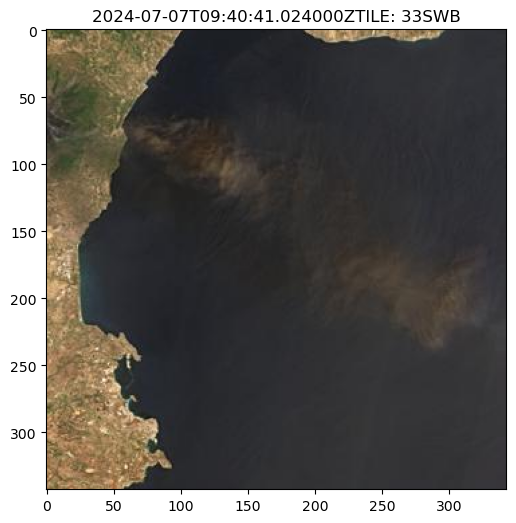

In [46]:
fig = plt.figure(figsize=(20, 40))
for i, product in enumerate(filtered_products, start=1):

    # This line takes care of downloading the quicklook
    quicklook_path = product.get_quicklook()
    
    img = mpimg.imread(quicklook_path)
    ax = fig.add_subplot(8, 2, i)
    ax.set_title(product.properties['dedl:beginningDateTime'] + "TILE: " +product.properties['dedl:tileIdentifier'])
    plt.imshow(img)
plt.tight_layout()

The quicklook shows effectively the ash plume caused by the eruptions.

EOProducts can be downloaded individually. The last image is going to be downloaded.

In [47]:
product_to_download = filtered_products[-1]
product_path = dag.download(product_to_download)
product_path

'/home/jovyan/dev-branch/DestinE-DataLake-Lab/HDA/EODAG/eodag_workspace/S2A_MSIL2A_20240707T094041_N0510_R036_T33SWB_20240707T131659'

The location property of this product now points to a local path.

In [21]:
product_to_download.location

'file:///home/jovyan/dev-branch/DestinE-DataLake-Lab/HDA/EODAG/eodag_workspace/S2A_MSIL2A_20240707T094041_N0510_R036_T33SWB_20240707T131659'